In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Discovering and forecasting extreme events via active learning in neural operators

Citation - Pickering, E., Guth, S., Karniadakis, G. E. & Sapsis, T. P. Discovering and forecasting extreme events via active learning in neural operators. Nat Comput Sci 2, 823–833 (2022).

## 1) SIR Pandemic Model

The pandemic model is the simple ‘susceptible, infected, recovered’ (SIR) model, proposed by Kermack and McKendrick and popularized by Anderson and May, with a two-dimensional stochastic infection rate.

$$
\frac{dS}{dt} = -\beta IS + \delta R, \\

\frac{dI}{dt} = \beta IS - \gamma I, \\

\frac{dR}{dt} = \gamma I - \delta R \\

$$
where 
* $\delta$ is the rate of immunity loss, 
* $\gamma$ is the recovery rate, and 
* $\beta$ is the infection rate. 
Here we take 
* $\delta = 0$ and 
* $\gamma = 0.1$ and 
* adjust $\beta$ from a scalar to a stochastic infection rate, $\beta (t)$, defined as
$$
\beta (t) = \beta_{0}(x \Phi(t) + \phi_{0})
$$
where $\Phi(t)$ is found via a Karhunen-Loeve expansion of a radial basis kernel with 
* $\sigma_{\beta}^2 = 0.1$ and 
* length scale $\mathcal{l}_{\beta} = 1$,
* $\beta_{0} = 3 \times 10^{-9}$, and
* $\phi_{0} = 2.55$ to ensure all infection rates are non-negative.

Initial conditions for the model are
* $I_{0} = 50$
* with total population $p = 10^8$,
* step size of $0.1$ days is used over $45$ days.

### Truth Values

In [2]:
from scipy.io import loadmat

# Load data from .mat file
truth_data = loadmat('./data/truth_data.mat')

# Accessing data
truth_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta', 'Y', 'px', 'py_standard', 'wx', 'x_int_standard'])

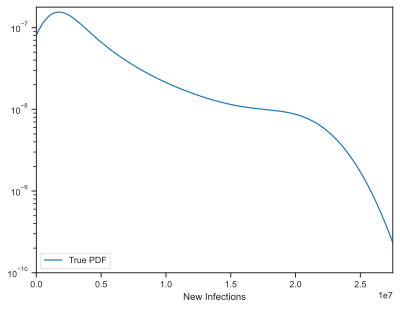

In [3]:
fig, ax = plt.subplots()
ax.semilogy(truth_data["x_int_standard"].reshape(10000), truth_data["py_standard"].reshape(10000), label ='True PDF' )
ax.set_xlim([0,2.75*10**7])
ax.set_ylim([10**-10,10**-6.75])
ax.legend(loc='lower left')
ax.set_xlabel('New Infections');

In [4]:
fig, ax = plt.subplots()
ax.pcolor(truth_data["Theta"][:,0].reshape(150, 150), truth_data["Theta"][:,1].reshape(150, 150), truth_data["wx"].reshape(150, 150))
ax.set_aspect('equal')
ax.annotate('Danger Scores',
xy=(-3, 5), xycoords='data',
xytext=(0.7, 0.95), textcoords='axes fraction',
horizontalalignment='right', verticalalignment='top',color='white') 
ax.set_ylabel('$\\theta_{2}$') 
ax.set_xlabel('$\\theta_{1}$')

Text(0.5, 0, '$\\theta_{1}$')

# DeepONet Data Generation

In [5]:
# Variables
iter_num = 0 # Iteration number
n_init = 3 # Initial data points
dim = 2 # Dimension of the stochastic excitation (infection rate)
T = 45  
dt = 0.1
gamma = 0.25
delta = 0
N_people = 10*10**7
I0 = 50

ndim = dim
nsteps = int(T/dt)
# Create the X to U map, which is actually theta to U
multiplier = 3*10**-9 # Special for the map
init_method = 'pdf'# How initial data are pulled
# DeepONet only needs a coarse version of the signal    
coarse = 4
rank = dim

In [6]:
from data_utils.class_noise import Noise

noise = Noise([0,1], sigma=0.1, ell=1)

In [7]:
from data_utils.inputs import GaussianInputs

mean, cov = np.zeros(ndim), np.ones(ndim)
domain = [ [-6, 6] ] * ndim
inputs = GaussianInputs(domain, mean, cov)

In [8]:
from data_utils.data import Theta_to_U, map_def, Theta_to_Z, DNO_Y_transform

# Determine the training data
Y = np.zeros((n_init,))
Theta = inputs.draw_samples(n_init, init_method)
Us = Theta_to_U(noise,Theta,nsteps,1,2)+2.55
Us = Us*multiplier

for i in range(0,n_init):
    I_temp = map_def(Us[i,:],gamma,delta,N_people,I0,T,dt, np.zeros(np.shape(Us[i,:])))
    Y[i] = I_temp[-1]

Y = Y.reshape(n_init,1)

In [9]:
# Transform to U and G values       
u_train = Theta_to_U(noise,Theta,nsteps,coarse,rank)
print(f"Shape of u_train:{u_train.shape}")
y_train = Theta_to_Z(Theta,rank)
print(f"Shape of y_train:{y_train.shape}")
G_train = DNO_Y_transform(Y)
print(f"Shape of G_train:{G_train.shape}")

Shape of u_train:(3, 112)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)
